In [115]:
import numpy as np
import scipy
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

TITANIC_PATH = "datasets/Titanic/train.csv"


import warnings
warnings.filterwarnings('ignore')

def load_titanic_data(titanic_path = TITANIC_PATH):
    return pd.read_csv(TITANIC_PATH)

tit_data = load_titanic_data()
#print(tit_data.info)

#separating labels and training, randomizing the sequence of the samples
tit_data2 = tit_data.copy()
X_train_df = (tit_data2.drop(["Survived", "Name"], axis = 1))
X_train = X_train_df.values
y_train = (tit_data["Survived"]).values
shuffle_index = np.random.permutation(891)    #0 to 890
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]


cols = X_train_df.columns
X_train = pd.DataFrame(X_train, columns = cols)


#making dummy variables for the string features
string_feats = X_train.iloc[:, [2, 9]]
gd = pd.get_dummies(string_feats, prefix = ['Sex', 'Embarked'])


#joining dummies and originals
X_train.drop(["Sex", "Embarked", "Cabin", "Ticket"], axis = 1, inplace = True)
X_train = pd.concat([X_train, gd], axis = 1 )


#putting median age in the Nans
from sklearn.impute import SimpleImputer
imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = imp_med.fit_transform(X_train)
X_train = pd.DataFrame(X_train_imp, columns = X_train.columns)
print(X_train.columns)

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [116]:
#Removing outliers

from collections import Counter
print("training set before removing outliers ", X_train.shape)

#removing otliers from the data
def remove_outlier_rows(f_name_array, given_number):
    outlier_cols = []
    
    for one_col in f_name_array:
        P1 = np.percentile(X_train[one_col], 25)
        P2 = np.percentile(X_train[one_col], 75)
        IQR = P2 - P1
        outlier_step = 1.5 * IQR
       
        indices_outlier_rows = X_train[(X_train[one_col] > P2 + outlier_step) | (X_train[one_col] < P1 - outlier_step)].index
        #print(X_train[(X_train[one_col] > P2 + IQR) | (X_train[one_col] < P1 - IQR)])
        outlier_cols.extend(indices_outlier_rows)
       
    check = Counter(outlier_cols)
    
    rows_to_remove = [k for k,v in check.items() if v > given_number]
    #print((rows_to_remove))

    X_train.drop(rows_to_remove, inplace = True)
    return rows_to_remove

rows_removed = remove_outlier_rows(["Age", "Parch", "SibSp", "Fare"], 2)
y_train = np.delete(y_train, rows_removed, 0)
print("training set shape ",X_train.shape)
print("training labels shape ", y_train.shape) 



training set before removing outliers  (891, 11)
training set shape  (866, 11)
training labels shape  (866,)


In [117]:

# X_train["fam_size"] = X_train["SibSp"] + X_train["Parch"]
# X_train.drop(["PassengerId", "SibSp", "Parch"], axis = 1, inplace = True)


from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

sgd_clf = SGDClassifier()
sgd_scrs = cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
print("(SGD non scaled)", sgd_scrs)

#using standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
sgd_scrs_scaled = cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")
print("(SGD scaled)", sgd_scrs_scaled)

#using randomforestclassifier unscaled
forest_clf = RandomForestClassifier(random_state = 42)
frst_scrs = cross_val_score(forest_clf, X_train, y_train, cv = 3, scoring = "accuracy")
print("(Random Forest unscaled)", frst_scrs)

#using randomforestclassifier scaled
forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
frst_scrs = cross_val_score(forest_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")
print("(Random Forest scaled)", frst_scrs)


(SGD non scaled) [0.61937716 0.63321799 0.42013889]
(SGD scaled) [0.70588235 0.75778547 0.75694444]
(Random Forest unscaled) [0.80622837 0.79584775 0.82291667]
(Random Forest scaled) [0.80276817 0.78200692 0.82986111]


<BarContainer object of 248 artists>

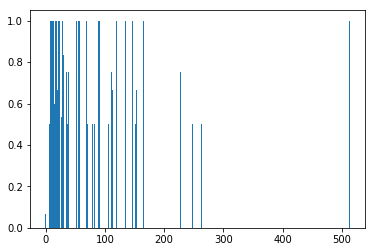

In [121]:
survivability = tit_data.groupby(["Fare"])y["Survived"].mean()
Pclass_values = tit_data.groupby(["Fare"]).groups.keys()
# print(a)
# at = [len(v) for k,v in te.groups.items()]
# at
plt.bar(Pclass_values, survivability)


In [106]:
tit_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
